# 定义库

In [14]:
%matplotlib inline 
#将那些用matplotlib绘制的图显示在页面里而不是弹出一个窗口

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler


from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

import gc

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
#计算最终要计算的参数的误差
#bnre.cpu()
def plot_conter(testset_x,testset_y,num=0,plot=True,model='NPE',gird=[0]):
    #if num>40:
    #    print('超出范围')
    sample=torch.tensor([])
    if model=='NPE':
        for i in range(num,num+1):
            #x_star,x_data=testset[i+40*(Tk//5-8)+40*(wm-3)*9+gggied*40*9*8]#*10表示只有第一个gird
            x_star=testset_y[i]
            #print(x_star.shape)
            x_data=testset_x[i]
            #x_data=preprocess_data(x_data)
            estimator_NPE.eval()
            with torch.no_grad():
                samples = estimator_NPE.flow(x_data[np.newaxis,:].cuda()).sample((2**18,)).cpu()
                samples = postprocess(samples)#.reshape((2**16,2)))
                sample=torch.cat([sample,samples], dim=0)

        sample=sample.reshape((-1,x_star.shape[-1]))
    
    if plot==True:
        plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings
        fig = corner(
            sample,
            #labels=LABELS,
            #bins=16,
            smooth=2,
            creds=(0.683, 0.954),
            #domain=([ 2., 50.], [ 10., 70.]),
            domain=(LOWER, UPPER),
            figsize=(8, 8),
        )
        print(sample.shape)
        print(x_star.shape)
        mark_point(fig, x_star)
    
    
    
    # 假设有一堆数据
    data1 = np.array(sample[:,0])
    data2 = np.array(sample[:,1])
    # 对数据进行排序（虽然期望不用，但是百分位数用）
    sorted_data1 = np.sort(data1)
    sorted_data2 = np.sort(data2)
    # 计算中心值(计算期望比最大概率以及中位数，在没有异常值的时候更合理)
    center_value1 = np.mean(sorted_data1)
    center_value2 = np.mean(sorted_data2)
    # 计算置信区间
    conf_interval_68_1 = np.percentile(sorted_data1, [16, 84])
    conf_interval_95_1 = np.percentile(sorted_data1, [2.3, 97.7])
    
    conf_interval_68_2 = np.percentile(sorted_data2, [16, 84])
    conf_interval_95_2 = np.percentile(sorted_data2, [2.3, 97.7])
    
    #conf_interval_68_1 = Confidence_Range(sorted_data1,0.68)
    #print(conf_interval_68_1)
    #conf_interval_68_2 = Confidence_Range(sorted_data2,0.68)

    #print(conf_interval_68_1)
    
    print(f'真实值：{x_star}')
    print("Wm的中心值:", center_value1)
    print("+σ:", conf_interval_68_1[1]-center_value1)
    print("-σ:", conf_interval_68_1[0]-center_value1)

    print("Tk的中心值:", center_value2)
    print("+σ:", conf_interval_68_2[1]-center_value2)
    print("-σ:", conf_interval_68_2[0]-center_value2)
    
    return sample
    
#real_ping_fortwo_grid()

# 网络1：参数推断

In [16]:
#固定的参数

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


def get_wave_plus_gaosnoise_t_gen_cai_NPE(data):
    nnnyyu=2**5
    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
    for i in range(data.shape[0]):
        estimator_NPE.eval()
        with torch.no_grad():
            samples = estimator_NPE.flow(data[i].reshape(1,4,2**14).cuda()).sample((nnnyyu,)).cpu()
            samples = postprocess(samples)
            
        samples_all[i,0,:]=samples[:,0,0]
        samples_all[i,1,:]=samples[:,0,1]
    return samples_all

In [59]:
data_set_dir='./data/'


#  "act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0.001,休眠率0.2,参数数目1024,参数层数7,流层9,中间层256,最佳损失-5.820067882537842,训练周期28",
#"act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0,休眠率0.2,参数数目1024,参数层数7,流层9,中间层512,最佳损失-3.325531482696533,训练周期35",
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
for act in [nn.ReLU]:
  for f in [0.0002]:#不能太大，也不能太小
    for weight_decay in [0.0001]:#不要太大，可以设置为0
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:#num>beishu,num>5*(8*3-1)
          for trans in [9]:#NF的残差块--画图的
           for beishu in [1024]:
            now= datetime.now()
            def fix_bn(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            class NPEWithEmbedding(nn.Module):#这个网络只要是1维的2的倍数就行
                def __init__(self,channels=3,beishu=4,canshu=5,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
                    super().__init__()#xiu gai canshu 2 wei 50

                    self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
                    self.embedding = ResNet(in_channels=channels,classes=beishu)

                def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
                    #print(self.embedding(x).shape)

                    return self.npe(theta, self.embedding(x))

                def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
                    return self.npe.flow(self.embedding(x))
                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            
            estimator_NPE= NPEWithEmbedding(channels=4,canshu=2,beishu=16,build=liu,hidden_features=[num] * transfomr,transforms=trans,activation=act).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            estimator_NPE.apply(weight_init);#channels：望远镜个数
            optimizer = optim.AdamW(estimator_NPE.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = NPELoss(estimator_NPE)

            list_los=[]
            list_losvail=[]
        
            with tqdm(range(2000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=50#10个周期不降就停
                i_all=0
                num=100#训练集总数#####################################################################################################
                num_v=40#验证集总数##############################################################################################################################################################
                datast=20#batch_size##############################################################################################################################################################
                nnum=num//datast
                nnum_v=num_v//datast
                
                for epoch in tq:
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    all_x = (torch.tensor(np.load(data_set_dir+f'train_data_{i_all}.npy').reshape(nnum,datast,4,-1),dtype=torch.float32))
                    all_y = (torch.tensor(np.load(data_set_dir+f'train_lens_per_{i_all}.npy').reshape(nnum,datast,2),dtype=torch.float32))

                    all_x_vail = (torch.tensor(np.load(data_set_dir+f'vail_data_{i_all}.npy').reshape(nnum_v,datast,4,-1),dtype=torch.float32))
                    all_y_vail = (torch.tensor(np.load(data_set_dir+f'vail_lens_per_{i_all}.npy').reshape(nnum_v,datast,2),dtype=torch.float32))

                    i_all+=1
                    if i_all>=300:#被改，原为300
                        i_all=0
                    
                    estimator_NPE.train()
                    losses = torch.stack([
                        step(loss(preprocess(all_y[i]).cuda(), all_x[i].cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    del all_x,all_y
                    
                    estimator_NPE.eval()
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(preprocess(all_y_vail[i]).cuda(), all_x_vail[i].cuda())
                            for i in range(nnum_v)
                        ])
                    
                    scheduler.step()#学习率衰减
                    
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

                    del all_x_vail,all_y_vail
                    
                    los=losses.mean().item()#类型不对，所以换名字
                    losval=val_losses.mean().item()#类型不对，所以换名字
                    
                    list_los.append(los)#话损失函数图
                    list_losvail.append(losval)#话损失函数图

                    # 储存监视
                    data1 = list_los
                    data2 = list_losvail
                    last= now
                    now = datetime.now()
                    # 打开一个文件用于写入
                    file = open(f'NPE_p_{f}_{weight_decay}_{transfomr}_{num}_{trans}_{beishu}.txt', 'w')#若文件存在，会清空其原有内容（覆盖文件）；反之，则创建新文件
                    file.write('last_last:'+str(last) + '\n')#指明要写入的内容
                    file.write('___last__:'+str(now) + '\n')#？写入的是啥内容？
                    
                    # 将每个元素写入文件中
                    for item1, item2 in zip(data1, data2):
                        file.write(str(item1) + ' ' + str(item2) + '\n')
                    
                    # 关闭文件
                    file.close()
                    
                    del losses,data1,data2
                    
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = estimator_NPE.state_dict()
                    else:
                        epochs_without_improvement += 1

                    # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
                    if epochs_without_improvement == patience:
                        estimator_NPE.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch-patience+1))
                        break
            torch.save(estimator_NPE, f'./net/NPE_p_{f}_{weight_decay}_{transfomr}_{num}_{trans}_{beishu}.pth')

  0%|          | 5/2000 [00:16<1:51:07,  3.34s/epoch, loss=2.37, val_loss=1.48]


FileNotFoundError: [Errno 2] No such file or directory: './data/train_data_5.npy'

## 评价

Text(0.5, 1.0, 'loss function')

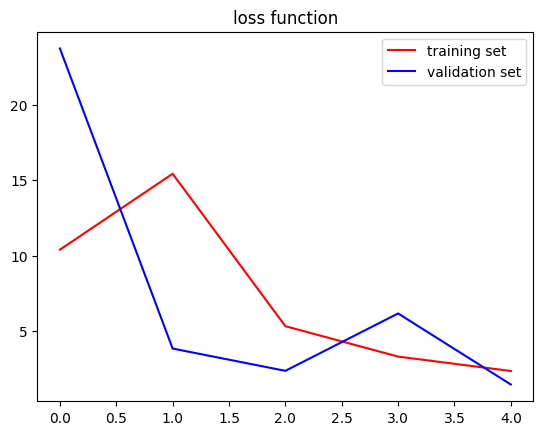

In [53]:
plt.plot(list_los, 'r', label='training set')#训练集损失函数
plt.plot(list_losvail,'b', label='validation set')#验证集损失函数
plt.legend(loc='upper right')
plt.title('loss function')

100%|██████████| 20/20 [00:09<00:00,  2.16pair/s]


KS statistic: 0.45454545454545453
p-value: 0.020047233548095234


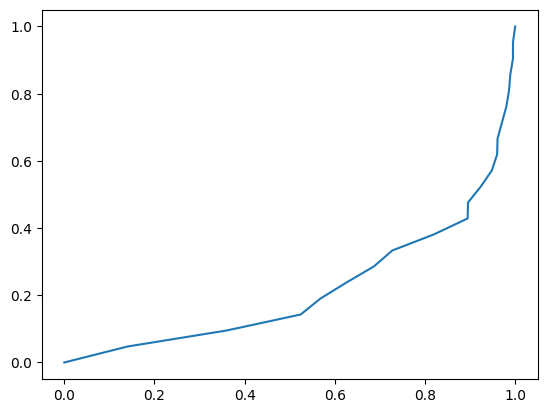

In [68]:
import torch

from torch import Tensor
from torch.distributions import Distribution
from tqdm import tqdm
from typing import *
import numpy as np
from lampe.utils import gridapply
def expected_coverage_mc_2(
    posterior: Callable[[Tensor], Distribution],
    pairs: Iterable[Tuple[Tensor, Tensor]],
    n: int = 1024,
    device: str = None,
) -> Tuple[Tensor, Tensor]:
    ranks = []
    
    theta_d_save=[]
    theta_p_save=[]
    with torch.no_grad():
        for theta, x in tqdm(pairs, unit='pair'):
#             if theta[0][0]<=5 or theta[0][0]>=7:
#                 continue
#             if theta[0][1]<=50 or theta[0][1]>=70:
#                 continue
            #if theta[0][0]!=6 or theta[0][1]!=60:
            #    continue              
            theta_d_save.append(np.array(postprocess(theta.cpu())))
            if device is not None:
                theta, x = preprocess(theta).to(device), (x).to(device)#每次需要改探测器数目
            dist = posterior(x)
            samples = dist.sample((n,))
            mask = dist.log_prob(theta) < dist.log_prob(samples)
            rank = mask.sum() / mask.numel()
            
            theta_p_save.append(np.array(postprocess(samples.cpu())))
            ranks.append(rank)
            
    ranks = torch.stack(ranks).cpu()
    ranks = torch.cat((ranks, ranks.new_tensor((0.0, 1.0))))
    return (
        torch.sort(ranks).values,
        torch.linspace(0, 1, len(ranks)),
    ),(theta_d_save,theta_p_save)

from scipy import stats

for SSRRNN in [8]:
    base_data='./data/test/'
    use_data=f'theta_{SSRRNN}.h5'
    testset=H5Dataset(base_data+use_data)
    (npe_levels, npe_coverages),(theta_d_save,theta_p_save)= expected_coverage_mc_2(estimator_NPE.flow, testset, device='cuda')
    observed_cdf = np.sort(npe_levels)
    theoretical_cdf = np.linspace(0,1,len(npe_levels))

    # perform KS test
    statistic, p_values = stats.ks_2samp(observed_cdf, theoretical_cdf)

    print("KS statistic:", statistic)
    print("p-value:", p_values)
    plt.plot(observed_cdf,theoretical_cdf)

## 推断

### PointNet

In [99]:
class SimplifiedPointNet(nn.Module):
    def __init__(self, input_dim=2, num_classes=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        B, N, D = x.size()
        x = x.view(-1, D)
        x = self.mlp(x)
        x = x.view(B, N, -1)
        x = torch.max(x, dim=1)[0]######这是核心，毕竟我们是后验分布推断，这个采样的顺序对结果应该没有影响，或许还有其他的，暂时先不考虑###############
        return self.classifier(x)

In [100]:
def generate_2d_distribution(num_samples, num_points, class_label):
    """生成二维高斯分布点云"""
    if class_label == 0:
        # 类别0：圆形高斯分布
        mean = [0, 0]
        cov = [[1, 0], [0, 1]]
    else:
        # 类别1：椭圆形高斯分布（强相关性）
        mean = [0, 0]
        cov = [[1, 0.8], [0.8, 1]]
    
    # 生成点云
    points = np.random.multivariate_normal(mean, cov, size=(num_samples, num_points))
    return torch.FloatTensor(points), torch.LongTensor([class_label] * num_samples)

# 生成数据集
num_samples_per_class = 500
num_points = 256  # 每个样本采样256个点

# 生成类别0和1的数据
X0, y0 = generate_2d_distribution(num_samples_per_class, num_points, 0)
X1, y1 = generate_2d_distribution(num_samples_per_class, num_points, 1)

# 合并并打乱
X = torch.cat([X0, X1], dim=0)
y = torch.cat([y0, y1], dim=0)
indices = torch.randperm(len(X))
X, y = X[indices], y[indices]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X.numpy(), y.numpy(), test_size=0.2, random_state=42
)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [101]:
def train_pointnet(model, train_loader, test_loader, epochs=50, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_accs = [], []
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            
            # 计算损失
            loss_cls = criterion(outputs, batch_y)
            total_loss = loss_cls
            
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()
        
        # 测试阶段
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                pred = outputs.argmax(dim=1)
                correct += (pred == batch_y).sum().item()
        
        # 记录指标
        train_loss = epoch_loss / len(train_loader)
        test_acc = correct / len(test_loader.dataset) * 100
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Acc: {test_acc:.2f}%")
    
    # 绘制曲线
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model

Epoch 1/50 | Train Loss: 0.3574 | Test Acc: 99.50%
Epoch 2/50 | Train Loss: 0.0013 | Test Acc: 100.00%
Epoch 3/50 | Train Loss: 0.0005 | Test Acc: 100.00%
Epoch 4/50 | Train Loss: 0.0003 | Test Acc: 100.00%
Epoch 5/50 | Train Loss: 0.0003 | Test Acc: 100.00%
Epoch 6/50 | Train Loss: 0.0002 | Test Acc: 100.00%
Epoch 7/50 | Train Loss: 0.0086 | Test Acc: 100.00%
Epoch 8/50 | Train Loss: 0.0024 | Test Acc: 100.00%
Epoch 9/50 | Train Loss: 0.0043 | Test Acc: 100.00%
Epoch 10/50 | Train Loss: 0.0008 | Test Acc: 100.00%
Epoch 11/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epoch 12/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epoch 13/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epoch 14/50 | Train Loss: 0.0002 | Test Acc: 100.00%
Epoch 15/50 | Train Loss: 0.0001 | Test Acc: 100.00%
Epoch 16/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epoch 17/50 | Train Loss: 0.0002 | Test Acc: 100.00%
Epoch 18/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epoch 19/50 | Train Loss: 0.0000 | Test Acc: 100.00%
Epo

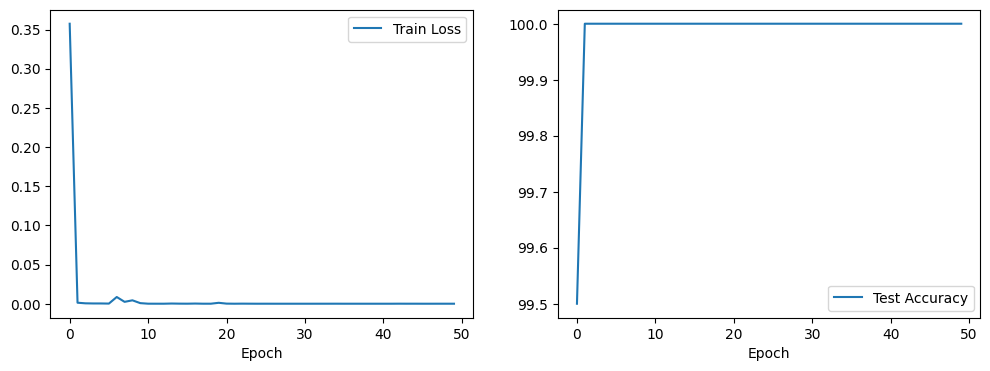

In [102]:
# 定义数据加载器
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 初始化模型并训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimplifiedPointNet(input_dim=2, num_classes=2)
model = train_pointnet(model, train_loader, test_loader, epochs=50, device=device)

In [115]:
batch_x[0:1,].shape

torch.Size([1, 256, 2])

In [125]:
model.eval()
correct = 0
with torch.no_grad():
    print(model(batch_x[0:1,].cuda()))
    shuffled_indices = torch.randperm(256)
    shuffled_points = batch_x[0:1,shuffled_indices,:]
    print(model(shuffled_points.cuda()))########打乱不影响结果#########
    probs = torch.softmax(model(batch_x[0:16,].cuda()), dim=1).cpu().numpy()  # 形状: (B, 2)
    print(probs[:,1],batch_y[0:16,])

tensor([[-10.3563,  11.5086]], device='cuda:0')
tensor([[-10.3563,  11.5086]], device='cuda:0')
[1.0000000e+00 9.9999988e-01 9.9998569e-01 4.1049374e-13 1.7445594e-10
 2.3109643e-09 1.2158696e-11 6.0113841e-12] tensor([1, 1, 1, 0, 0, 0, 0, 0])


# 网络2：时间序列推断

In [82]:
#非采样器的
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。

aaaaa=[]

import gc

for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x

                    return self.jia_relu(self.layer(x)+residual)

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model= ResNet(in_channels=4,classes=1).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model.apply(weight_init)
            
            optimizer = optim.AdamW(model.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.BCEWithLogitsLoss()

            list_los=[]
            list_losvail=[]
        
            with tqdm(range(10000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=30#10个周期不降就停
                i=0
                num=100#总数
                num_v=40
                datast=20#batch_size
                nnum=num//datast
                nnum_v=num_v//datast
                
                i_all=0
                
                for epoch in tq:
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    all_x = (torch.tensor(np.load(data_set_dir+f'train_data_{i_all}.npy').reshape(nnum,datast,4,-1),dtype=torch.float32))
                    all_y = (torch.tensor(np.load(data_set_dir+f'train_targer_{i_all}.npy').reshape(nnum,datast,1),dtype=torch.float32))

                    all_x_vail = (torch.tensor(np.load(data_set_dir+f'vail_data_{i_all}.npy').reshape(nnum_v,datast,4,-1),dtype=torch.float32))
                    all_y_vail = (torch.tensor(np.load(data_set_dir+f'vail_targer_{i_all}.npy').reshape(nnum_v,datast,1),dtype=torch.float32))

                    i_all+=1
                    if i_all>=300:#被改，原为300
                        i_all=0

                    model.train()
                    losses = torch.stack([
                        step(loss(model(all_x[i].cuda()), all_y[i].cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    del all_x,all_y
                    
                    model.eval()
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(model(all_x_vail[i].cuda()), all_y_vail[i].cuda())
                            for i in range(nnum_v)
                        ])
                    
                    scheduler.step()#学习率衰减
                    
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

                    del all_x_vail,all_y_vail
                    
                    los=losses.mean().item()#类型不对，所以换名字
                    losval=val_losses.mean().item()#类型不对，所以换名字
                    
                    list_los.append(los)#话损失函数图
                    list_losvail.append(losval)#话损失函数图

                    # 储存监视
                    
                    
                    
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = model.state_dict()
                    else:
                        epochs_without_improvement += 1

                    # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
                    if epochs_without_improvement == patience:
                        model.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch-patience+1))
                        break
                        
            torch.save(model.state_dict(),f'/home/suntianyang/work5/ligo/net/NPE_mid_t_lens_ce.pth')
            aaaaa.append('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-10],len(list_los)-10))
            print('act{}学习率{},正则化{},,参数数目{},参数层数{},流层 {},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-10],len(list_los)-10))

  0%|          | 5/10000 [00:11<6:28:32,  2.33s/epoch, loss=0, val_loss=0]    


FileNotFoundError: [Errno 2] No such file or directory: './data/train_data_5.npy'

## 评价

# 网络3：参数联合时间序列推断

In [ ]:
#【data——参数推断】（不用再训练了，冻结参数）————预测网络增加输出维度
#data——RES————————————————————————————————特征融合————注意力————结果



# 冻结A网络的所有参数
for param in netA.parameters():
    param.requires_grad = False
netA.eval()  # 用之前设置A网络为评估模式，停止BatchNorm等的统计更新

class AttentionFusion(nn.Module):
    def __init__(self, original_dim=100, dist_dim=2):
        super().__init__()
        # 原始数据特征提取
        self.original_encoder = nn.Linear(original_dim, 64)
        # 分布参数特征提取
        self.dist_encoder = nn.Linear(dist_dim, 64)
        # 注意力权重计算
        self.attention = nn.Linear(64 * 2, 1)
        # 分类层
        self.fc = nn.Linear(64, 2)

    def forward(self, original_input, dist_input):
        feat_original = self.original_encoder(original_input)  # (B, 64)
        feat_dist = self.dist_encoder(dist_input)              # (B, 64)
        
        # 计算注意力权重
        combined = torch.cat([feat_original, feat_dist], dim=1)  # (B, 128)————特征拼接
        attn_weights = torch.sigmoid(self.attention(combined))   # (B, 1)
        
        # 加权融合
        fused = attn_weights * feat_original + (1 - attn_weights) * feat_dist
        return self.fc(fused)

## 评价